In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import re

import json 
import torch
import json_repair
import pandas as pd
from glob import glob 
from openai import OpenAI
from pydantic import BaseModel
from dotenv import load_dotenv
from pqdm.processes import pqdm
from datasets import Dataset, load_dataset
from trl import SFTTrainer
from peft import AutoPeftModelForCausalLM, LoraConfig
from transformers import (AutoTokenizer, 
                          AutoModelForCausalLM, 
                          TrainingArguments, 
                          pipeline)


# 제작한 데이터세 불러오기 
file_list = glob("./data/*.csv")
print(file_list)

df = pd.concat([pd.read_csv(file) for file in file_list])
df.shape

/home/admin/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['./data/보험 상담_final_20250315_013253.csv', './data/강의_세미나_홍보글_final_20250315_015358.csv', './data/중고나라_게시물_final_20250315_015358.csv', './data/은행 상담_final_20250315_013253.csv', './data/이벤트_안내글_final_20250315_015358.csv', './data/모임_동호회_홍보글_final_20250315_015358.csv', './data/쇼핑 고객 서비스_final_20250315_013253.csv', './data/제품_리뷰글_final_20250315_015358.csv']


(807, 9)

In [2]:
def extract_placeholder_mapping(original_text, transformed_text, allowed_types):
    allowed_pattern = re.compile(r'\[(' + '|'.join(allowed_types) + r')\d*\]')
    generic_pattern = re.compile(r'(\[[^]]+\])')

    mapping = {}

    orig_lines = original_text.splitlines()
    trans_lines = transformed_text.splitlines()
    n_lines = min(len(orig_lines), len(trans_lines))

    for idx in range(n_lines):
        orig_line = orig_lines[idx]
        trans_line = trans_lines[idx]

        parts = re.split(generic_pattern, trans_line)
        orig_pos = 0

        for i, part in enumerate(parts):
            if allowed_pattern.match(part):
                # placeholder 발견
                # 다음 literal을 찾음
                next_literal = parts[i + 1] if i + 1 < len(parts) else ''
                
                # 다음 literal이 존재하면, 그 literal까지의 텍스트를 추출
                if next_literal:
                    next_idx = orig_line.find(next_literal, orig_pos)
                    if next_idx != -1:
                        replaced_text = orig_line[orig_pos:next_idx]
                        orig_pos = next_idx
                    else:
                        # 다음 literal을 못 찾으면 끝까지
                        replaced_text = orig_line[orig_pos:]
                        orig_pos = len(orig_line)
                else:
                    # 다음 literal이 없으면 남은 텍스트 전체
                    replaced_text = orig_line[orig_pos:]
                    orig_pos = len(orig_line)

                replaced_text = replaced_text.strip()
                if replaced_text:
                    mapping[replaced_text] = part

            else:
                # literal인 경우, 원본에서 위치 업데이트
                found_idx = orig_line.find(part, orig_pos)
                if found_idx != -1:
                    orig_pos = found_idx + len(part)

    return mapping

df.head(2)

,origin_data,category,generate_score,generate_reason,anonymized_data,anonymized_prompt,validate_score,validate_reason,mapping
0,"상담사: ""안녕하세요, 김은주 고객님! 상담사 이현준입니다. 오늘 보험 상담 도와드...",보험 상담,5,"데이터는 모든 평가 기준을 완벽히 만족합니다. \n\n1. 개인정보 포함: 이름, ...","상담사: ""안녕하세요, [PERSON1] 고객님! 상담사 [PERSON2]입니다. ...",입력 데이터에 포함된 모든 개인정보를 위 placeholder를 사용하여 비식별화 ...,5,"모든 개인정보가 적절하게 비식별화되었습니다. 이름, 생년월일, 연락처, 주소, 이메...","{'김은주': '[PERSON1]', '이현준': '[PERSON2]', '1985..."
1,"상담사: ""안녕하세요, 김하나 고객님. 보험 상담을 도와드릴 김상진입니다. 생년월일...",보험 상담,5,데이터는 모든 평가 기준을 완벽히 만족하고 있습니다. \n1. 개인정보 포함: 이름...,"상담사: ""안녕하세요, [PERSON1] 고객님. 보험 상담을 도와드릴 [PERSO...",입력 데이터에 포함된 모든 개인정보를 위 placeholder를 사용하여 비식별화 ...,5,"모든 개인정보가 적절하게 비식별화되었으며, 동일한 개인정보는 일관된 placehol...","{'김하나': '[PERSON1]', '김상진': '[PERSON2]', '1985..."


In [3]:
print(df["origin_data"].iloc[20])
print("--------------")
print(df["anonymized_data"].iloc[20])

상담사: "안녕하세요, 김미영 고객님. 보험 상담을 도와드릴 홍성철입니다. 생일이 1985년 4월 12일로 등록되어 있습니다. 맞으신가요?"

고객: "네, 맞습니다. 요즘 보험에 대해 좀 더 알아보고 싶어서요."

상담사: "현재 사용 중인 연락처는 010-1234-5678이 맞으신가요? 이메일은 kimmyoung85@gmail.com으로 알고 있습니다."

고객: "네, 두 정보 모두 정확합니다."

상담사: "감사합니다. 현재 저희 보험 상품 중 보장성 보험에 관심이 있으신 걸로 알고 있습니다. 혹시 주소는 예전에 등록된 서울시 용산구 이태원로 123으로 변경된 부분이 없으신가요?"

고객: "아, 주소는 이제 서울시 성동구 왕십리로 456으로 변경되었습니다."

상담사: "확인 감사합니다. 그러면 현재 보장 내용이나 보험료 등에 대해 더 자세히 설명해 드려도 될까요?"

고객: "네, 좋습니다. 제가 현재 가입된 보험이랑 비교해서 어떤 차이가 있는지도 궁금합니다."

상담사: "알겠습니다. 고객님의 현재 보험 내용과 저희 상품을 비교해서 최적의 선택을 도와드릴 수 있도록 하겠습니다. 더 궁금하신 점이 있으면 언제든지 말씀해 주세요."

고객: "네, 감사합니다. 혹시 카카오톡 ID로도 안내를 받을 수 있을까요? 아이디는 kimmykakao입니다."

상담사: "물론입니다. 카카오톡으로도 정보를 보내드리겠습니다. 상담 진행 중 궁금한 점이 있으면 언제든지 메시지 주세요."

고객: "알겠습니다. 잘 부탁드립니다."
--------------
상담사: "안녕하세요, [PERSON1] 고객님. 보험 상담을 도와드릴 [PERSON2]입니다. 생일이 [DATEOFBIRTH1]로 등록되어 있습니다. 맞으신가요?"

고객: "네, 맞습니다. 요즘 보험에 대해 좀 더 알아보고 싶어서요."

상담사: "현재 사용 중인 연락처는 [CONTACT1]이 맞으신가요? 이메일은 [EMAIL1]으로 알고 있습니다."

고객: "네, 두 정보 모두 정확합니다."

상담사: "감사합

In [4]:
print(df["origin_data"].iloc[-2])
print("--------------")
print(df["anonymized_data"].iloc[-2])

서울책사랑 동호회 안내

안녕하세요, 서울책사랑 동호회입니다! 📚 저희는 책을 사랑하는 사람들이 모여 다양한 책을 읽고, 함께 이야기 나누는 모임입니다. 매달 한 권의 책을 선정하여 읽고, 이를 바탕으로 토론과 감상 나누기를 진행하고 있습니다. 책을 좋아하는 분들이라면 누구나 환영합니다!

다음 모임은 10월 15일 토요일 오후 3시, 서울 종로구 북촌로 15번지에 위치한 '북촌 책방'에서 열립니다. 이번 달의 선정 도서는 '김영하의 여행의 이유'입니다. 모임 후에는 인근 카페에서 다과를 즐기며 자유롭게 이야기를 나눌 예정입니다. ☕️

모임에 참여를 원하시는 분들은 이메일 seoulbooklover@gmail.com 또는 카카오톡 ID 'booklover123'로 연락 주시면 됩니다. 가입 절차는 간단하며, 첫 모임은 무료로 참여 가능합니다. 이후 정기 회원으로 가입하실 경우, 월 회비는 1만 원이며, 계좌번호는 우리은행 1002-123-456789 (예금주: 김서연)로 입금해 주시면 됩니다.

문의 사항이 있으신 분들은 언제든지 연락 주세요! 새로운 책과 사람들을 만날 생각에 벌써부터 설레입니다. 많은 참여 부탁드립니다. 📖✨
--------------
서울책사랑 동호회 안내

안녕하세요, 서울책사랑 동호회입니다! 📚 저희는 책을 사랑하는 사람들이 모여 다양한 책을 읽고, 함께 이야기 나누는 모임입니다. 매달 한 권의 책을 선정하여 읽고, 이를 바탕으로 토론과 감상 나누기를 진행하고 있습니다. 책을 좋아하는 분들이라면 누구나 환영합니다!

다음 모임은 10월 15일 토요일 오후 3시, [LOCATION1]에 위치한 '[LOCATION2]'에서 열립니다. 이번 달의 선정 도서는 '[PERSON1]의 여행의 이유'입니다. 모임 후에는 인근 카페에서 다과를 즐기며 자유롭게 이야기를 나눌 예정입니다. ☕️

모임에 참여를 원하시는 분들은 이메일 [EMAIL1] 또는 카카오톡 ID '[KAKAO_ID1]'로 연락 주시면 됩니다. 가입 절차는 간단하며, 첫 모임은 무

In [5]:
df["mapping"] = df["mapping"].map(lambda x: str(x))

In [6]:
import datasets 

dataset = datasets.Dataset.from_pandas(df)

def get_chat_format(element):
    system_prompt = "너는 개인정보를 비식별화하는 Assistant야. 너는 주어진 데이터를 바탕으로 개인정보를 비식별화하는 작업을 해야해."

    return {
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": element["origin_data"]},
            {"role": "assistant", "content": element["anonymized_data"]},
        ], 
        "label": element["mapping"]
    }

dataset = dataset.map(get_chat_format, remove_columns=dataset.features, batched=False)
dataset = dataset.shuffle(seed=42)
dataset = dataset.train_test_split(test_size=0.1, seed=42)

Map: 100%|██████████| 807/807 [00:00<00:00, 8748.00 examples/s]


In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['messages', 'label'],
        num_rows: 726
    })
    test: Dataset({
        features: ['messages', 'label'],
        num_rows: 81
    })
})

In [8]:
dataset["train"][0]

{'messages': [{'content': '너는 개인정보를 비식별화하는 Assistant야. 너는 주어진 데이터를 바탕으로 개인정보를 비식별화하는 작업을 해야해.',
   'role': 'system'},
  {'content': '상담사: "안녕하세요, 고객님 쇼핑몰 고객센터입니다. 무엇을 도와드릴까요?"\n\n고객: "안녕하세요, 김지영입니다. 제가 지난주에 주문한 주문번호 1234567890번 상품이 아직 도착하지 않아서요. 제 배송지 주소는 서울시 강남구 테헤란로 123입니다."\n\n상담사: "확인해드리겠습니다, 김지영님. 잠시만 기다려 주세요. 혹시 생년월일과 등록된 연락처를 알려주실 수 있을까요?"\n\n고객: "네, 생년월일은 1990년 5월 20일이고, 등록된 연락처는 010-9876-5432입니다."\n\n상담사: "확인 감사합니다. 조회해본 결과 해당 상품은 어제 발송된 것으로 확인됩니다. 아마도 늦어도 내일 안으로는 도착할 것으로 보입니다. 불편을 드려 죄송합니다."\n\n고객: "아, 그렇군요. 알겠습니다. 근데 이번에 결제를 했을 때 계좌 번호가 잘못 기재된 것 같아서 확인하고 싶어요. 제 계좌번호는 123-456-789123 입니다."\n\n상담사: "네, 확인해보니 계좌번호도 정상적으로 등록되어 있고 결제도 문제없이 완료된 것으로 나옵니다. 혹시 더 궁금한 점 있으실까요?"\n\n고객: "아니요, 그럼 물건 도착할 때까지 기다리면 되겠네요. 친절한 상담 감사합니다."\n\n상담사: "네, 김지영님. 추가로 궁금한 사항이 생기시면 언제든지 연락 주세요. 좋은 하루 되세요!"',
   'role': 'user'},
  {'content': '상담사: "안녕하세요, 고객님 쇼핑몰 고객센터입니다. 무엇을 도와드릴까요?"\n\n고객: "안녕하세요, [PERSON1]입니다. 제가 지난주에 주문한 주문번호 1234567890번 상품이 아직 도착하지 않아서요. 제 배송지 주소는 [ADDRESS1]입니다."\n\n상담사: "확인해드리겠습니다,

In [9]:
lora_alpha = 32
lora_r = 64
learning_rate = 2e-4

peft_config = LoraConfig(
        lora_alpha=lora_alpha,
        lora_dropout=0.05,
        r=lora_r,
        bias="none",
        target_modules=[
            "q_proj",
            "up_proj",
            "o_proj",
            "k_proj",
            "down_proj",
            "gate_proj",
            "v_proj"],
        task_type="CAUSAL_LM",
)

save_dir = f"./model/model_{learning_rate}_alpha-{lora_alpha}_r-{lora_r}"

args = TrainingArguments(
    output_dir=f"{save_dir}", 
    num_train_epochs=2,          
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,  
    optim="adamw_torch_fused",    
    logging_steps=2,            
    save_strategy="epoch",        
    learning_rate=learning_rate,
    bf16=True,                    
    tf32=True,                    
    max_grad_norm=0.3,            
    warmup_ratio=0.03,            
    lr_scheduler_type="constant", 
    push_to_hub=True,             
    report_to="wandb",            
)

In [10]:
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.padding_side = 'right'  
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards: 100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


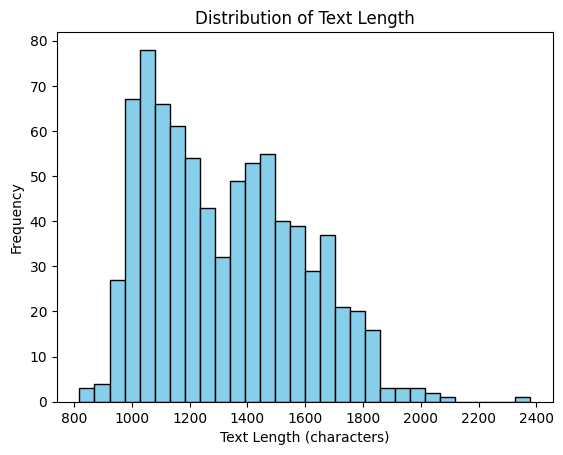

In [11]:
df["length"] = df["origin_data"].apply(len) + df["anonymized_data"].apply(len)

import matplotlib.pyplot as plt

plt.hist(df["length"], bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Text Length")
plt.xlabel("Text Length (characters)")
plt.ylabel("Frequency")
plt.show()

In [12]:
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    max_seq_length=2400,
    peft_config=peft_config,
    tokenizer=tokenizer,
    packing=True,
)

trainer.train()

trainer.save_model(f"{save_dir}")

/home/admin/.venv/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length, packing. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/home/admin/.venv/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:195: UserWarning: You passed a `packing` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/home/admin/.venv/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/home/admin/.venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss
2,1.068700
4,0.915300
6,0.787900
8,0.707300
10,0.639600
12,0.624400
14,0.567400
16,0.555100
18,0.551700
20,0.546000


/home/admin/.venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


In [13]:
del model
del tokenizer
torch.cuda.empty_cache()

In [14]:
# 학습한 모델을 경로를 지정합니다.
peft_model_id = f"{save_dir}"

# PEFT 어댑터를 통해 사전 학습된 모델을 로드합니다.
fine_tuned_model = AutoPeftModelForCausalLM.from_pretrained(
  peft_model_id,
  device_map="auto",
  torch_dtype=torch.float16
).to("cuda")

# 토크나이저 로드합니다.
tokenizer = AutoTokenizer.from_pretrained(peft_model_id)
tokenizer.padding_side = 'right'  
tokenizer.pad_token = tokenizer.eos_token


Loading checkpoint shards: 100%|██████████| 4/4 [00:06<00:00,  1.51s/it]


In [15]:
dataset["test"]

Dataset({
    features: ['messages', 'label'],
    num_rows: 81
})

In [16]:
pipe = pipeline("text-generation", model=fine_tuned_model, tokenizer=tokenizer, device_map="auto")

prompt = pipe.tokenizer.apply_chat_template(dataset["test"][-2]["messages"][:2], tokenize=False, add_generation_prompt=True)
print(prompt)

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCaus

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

너는 개인정보를 비식별화하는 Assistant야. 너는 주어진 데이터를 바탕으로 개인정보를 비식별화하는 작업을 해야해.<|eot_id|><|start_header_id|>user<|end_header_id|>

서울책사랑 동호회 신규 회원 모집 안내

안녕하세요, 서울책사랑 동호회입니다! 📚 저희는 책을 사랑하는 사람들이 모여 다양한 책을 함께 읽고 토론하는 모임입니다. 이번에 새로운 회원을 모집하게 되어 안내드립니다.

활동 내용: 매월 둘째 주 토요일에 모여 선정된 책을 읽고 자유롭게 토론합니다. 또한, 분기별로 유명 작가 초청 강연과 독서 여행도 계획하고 있습니다.

모임 일시: 2023년 11월 11일 토요일 오후 3시

장소: 서울특별시 종로구 북촌로 45, 3층 '북토크 카페'

가입 방법: 관심 있으신 분들은 아래 연락처로 이름과 연락처를 보내주시면 됩니다. 가입비는 1회 10,000원이며, 국민은행 123-456-789012 (예금주: 김서현)로 입금 부탁드립니다.

연락처: 
- 이메일: seoulbooklover@gmail.com
- 카카오톡 ID: booklover123
- 전화번호: 010-1234-5678 (담당자: 이민호)

저희와 함께 책 읽는 즐거움을 나누고 싶으신 분들의 많은 참여 바랍니다! 🌟

문의 사항이 있으시면 언제든지 연락 주세요. 감사합니다! 📖✨<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [17]:
outputs = pipe(
    prompt, 
    max_new_tokens=512, 
    do_sample=False, 
    temperature=0.1, 
    top_k=40, 
    top_p=0.1, 
    eos_token_id=pipe.tokenizer.eos_token_id, 
    pad_token_id=pipe.tokenizer.pad_token_id
)


/home/admin/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/admin/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/admin/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:623: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `40` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
Starting from v4.46, the `logits` model output will have the same type as the mo

In [18]:
output_text = outputs[0]["generated_text"][len(prompt):]
print(output_text)

서울책사랑 동호회 신규 회원 모집 안내

안녕하세요, 서울책사랑 동호회입니다! 📚 저희는 책을 사랑하는 사람들이 모여 다양한 책을 함께 읽고 토론하는 모임입니다. 이번에 새로운 회원을 모집하게 되어 안내드립니다.

활동 내용: 매월 둘째 주 토요일에 모여 선정된 책을 읽고 자유롭게 토론합니다. 또한, 분기별로 유명 작가 초청 강연과 독서 여행도 계획하고 있습니다.

모임 일시: 2023년 11월 11일 토요일 오후 3시

장소: [LOCATION1], 3층 '북토크 카페'

가입 방법: 관심 있으신 분들은 아래 연락처로 이름과 연락처를 보내주시면 됩니다. 가입비는 1회 10,000원이며, 국민은행 [ACCOUNT1] (예금주: [PERSON1])로 입금 부탁드립니다.

연락처: 
- 이메일: [EMAIL1]
- 카카오톡 ID: [KAKAO_ID1]
- 전화번호: [CONTACT1] (담당자: [PERSON2])

저희와 함께 책 읽는 즐거움을 나누고 싶으신 분들의 많은 참여 바랍니다! 🌟

문의 사항이 있으시면 언제든지 연락 주세요. 감사합니다! 📖✨


In [19]:
input_text = dataset["test"][-2]["messages"][1]["content"]
print(input_text)

서울책사랑 동호회 신규 회원 모집 안내

안녕하세요, 서울책사랑 동호회입니다! 📚 저희는 책을 사랑하는 사람들이 모여 다양한 책을 함께 읽고 토론하는 모임입니다. 이번에 새로운 회원을 모집하게 되어 안내드립니다.

활동 내용: 매월 둘째 주 토요일에 모여 선정된 책을 읽고 자유롭게 토론합니다. 또한, 분기별로 유명 작가 초청 강연과 독서 여행도 계획하고 있습니다.

모임 일시: 2023년 11월 11일 토요일 오후 3시

장소: 서울특별시 종로구 북촌로 45, 3층 '북토크 카페'

가입 방법: 관심 있으신 분들은 아래 연락처로 이름과 연락처를 보내주시면 됩니다. 가입비는 1회 10,000원이며, 국민은행 123-456-789012 (예금주: 김서현)로 입금 부탁드립니다.

연락처: 
- 이메일: seoulbooklover@gmail.com
- 카카오톡 ID: booklover123
- 전화번호: 010-1234-5678 (담당자: 이민호)

저희와 함께 책 읽는 즐거움을 나누고 싶으신 분들의 많은 참여 바랍니다! 🌟

문의 사항이 있으시면 언제든지 연락 주세요. 감사합니다! 📖✨


In [20]:
mapping_result = extract_placeholder_mapping(
    input_text, 
    output_text, 
    allowed_types=(
        "PERSON", "CONTACT", "ADDRESS", "ACCOUNT", "DATEOFBIRTH", 
        "EMAIL", "LOCATION", "KAKO_ID", "TIWTTER_ID", "TELEGRAM_ID"))

print(mapping_result)

{'서울특별시 종로구 북촌로 45': '[LOCATION1]', '123-456-789012': '[ACCOUNT1]', '김서현': '[PERSON1]', 'seoulbooklover@gmail.com': '[EMAIL1]', '010-1234-5678': '[CONTACT1]', '이민호': '[PERSON2]'}


In [21]:
mapping_result

{'서울특별시 종로구 북촌로 45': '[LOCATION1]',
 '123-456-789012': '[ACCOUNT1]',
 '김서현': '[PERSON1]',
 'seoulbooklover@gmail.com': '[EMAIL1]',
 '010-1234-5678': '[CONTACT1]',
 '이민호': '[PERSON2]'}

In [22]:
import json_repair
json_repair.loads(dataset["test"][-2]["label"])

{'서울특별시 종로구 북촌로 45': '[LOCATION1]',
 '123-456-789012': '[ACCOUNT1]',
 '김서현': '[PERSON1]',
 'seoulbooklover@gmail.com': '[EMAIL1]',
 '010-1234-5678': '[CONTACT1]',
 '이민호': '[PERSON2]'}